In [1]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
import scipy.interpolate as sci
from mpl_toolkits.axes_grid1 import make_axes_locatable
from tqdm import tqdm

In [2]:
folder = 'results_final_Z_300322'
run= 'Sage_vlarge_all_allt_z0.0_quantile_raw_rm_mllteo'

pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
ys, pred = results['low_ys'], results['low_pred']
mstar_ys, mstar_pred = ys[:,0]+9, pred[:,0]+9
# mcold_ys, mcold_pred = ys[:,2]+9, pred[:,2]+9

Zy, Zpred = ys[:,2]+9, pred[:,2]+9
Coldy, Coldpred = ys[:,1]+9, pred[:,1]+9
sfr_ys, sfr_pred = ys[:,3], pred[:,3]
sfr100_ys, sfr100_pred = ys[:,4], pred[:,4]
Mbh_ys, Mbh_pred = ys[:,5]+9, pred[:,5]+9

Zy-=Coldy
Zpred-=Coldpred

ys = np.vstack([ mstar_ys, Coldy, Zy, sfr_ys, sfr100_ys, Mbh_ys]).T
pred = np.vstack([mstar_pred, Coldpred, Zpred, sfr_pred, sfr100_pred, Mbh_pred]).T

In [3]:
datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/vlarge_all_all_t_z0.0_None/data.pkl'), 'rb'))
from torch_geometric.data import Data
data=[]
for d in datat:
    if np.all(d.y.numpy()[np.arange(5,28)]>0):
        data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[[8,15,20,21,23,27]]))
    else:
#         print(d.y.numpy()[np.arange(5,27)]>0)
        continue
testidx = pickle.load(open(osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphStorage/tvt_idx/test_idx_rm.pkl'), 'rb'))

In [4]:
Xte = []
Xtr = []
Mhfte = []
Mhftr = []
ytr = []
yte = []
test_data = []
for i, d in tqdm(enumerate(data), total=len(data)):
    if i in testidx:
#         Xte.append(d.x.numpy()[0,:])
        Mhfte.append(d.x.numpy()[0,3])
        yte.append(d.y.numpy()[0])
        test_data.append(d.x.numpy())
    else:
#         Xtr.append(d.x.numpy()[0,:])
        Mhftr.append(d.x.numpy()[0,3])
        ytr.append(d.y.numpy()[0])

100%|████████████████████████████████████████████████████████| 108338/108338 [03:47<00:00, 476.01it/s]


In [5]:
# case='vlarge_all_4t_z0.0_None'

# data=pickle.load(open(f'../../../../../scratch/gpfs/cj1223/GraphStorage/{case}/data.pkl', 'rb'))
# testidx = pickle.load(open(osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphStorage/tvt_idx/test_idx.pkl'), 'rb'))

# Mhfte = []
# Mhftr = []
# ystr = []
# yste = []
# for i, d in enumerate(data):
#     if i in testidx:
#         Mhfte.append(d.x.numpy()[0,3])
#         yste.append(d.y.numpy()[0])
#     else:
#         Mhftr.append(d.x.numpy()[0,3])
#         ystr.append(d.y.numpy()[0])
# Mhfte=np.array(Mhfte)
# Mhftr=np.array(Mhftr)

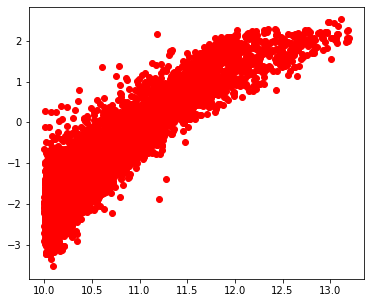

In [6]:
#trick to make splines work
Mhfte=np.array(Mhfte)
Mhftr=np.array(Mhftr)
Mhfte+=np.arange(len(Mhfte))/1e6
Mhftr+=np.arange(len(Mhftr))/1e6

yte=np.log10(np.vstack(yte))
ytr=np.log10(np.vstack(ytr))
fig , ax = plt.subplots(1, figsize=(6,5))

ax.plot(Mhfte,yte, 'ro',label =' M_halo-M_star data')
# ax.plot(Mhfte,splineMhftr(Mhfte), 'bo',label =' M_halo-M_star spline')

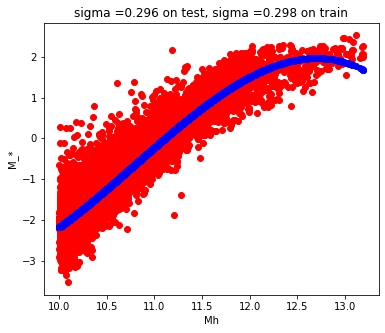

In [7]:
fig , ax = plt.subplots(1, figsize=(6,5))

a = np.array([Mhfte,yte[:,0]])
a = a[:,a[0,:].argsort()]
Mhfste, yste = np.copy(a)

a = np.array([Mhftr,ytr[:,0]])
a = a[:,a[0,:].argsort()]
Mhfstr, ystr = a

splineMhftr=sci.UnivariateSpline(Mhfstr, ystr)
r2 = r2_score(yste, splineMhftr(Mhfste))
ax.plot(Mhfste,yste, 'ro',label =' M_halo-M_star data')
ax.plot(Mhfste,splineMhftr(Mhfste), 'bo',label =' M_halo-M_star spline')
ax.set(title=f'sigma ={np.round(np.std(splineMhftr(Mhfste)-yste),3)} on test, sigma ={np.round(np.std(splineMhftr(Mhfstr)-ystr),3)} on train',\
       xlabel='Mh', ylabel='M_*')

Mhfte-=np.arange(len(Mhfte))/1e6
Mhftr-=np.arange(len(Mhftr))/1e6

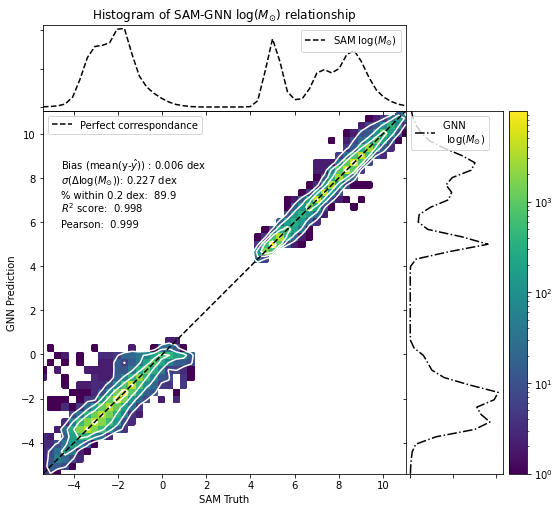

In [8]:
from matplotlib.ticker import NullFormatter
from scipy import stats

n=0
target=r"log($M_{\odot}$)"
# target=r"$v_{disk}$"
pred=pred.flatten()
ys = ys.flatten()
nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.63
bottom, height = 0.1, 0.63
bottom_h = left_h = left + width
# rect_Cbar = [0, bottom, 0.1, height]
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.15]
rect_histy = [left_h, bottom, 0.15+0.06, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))
# axCbar = plt.axes(rect_Cbar)
axHist = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)

bins=50
l=0.01
xt=0.05
yt=0.8
n_contour=4
# the scatter plot:
vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                            np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
axHist.set(xlabel='SAM Truth',ylabel='GNN Prediction')
axHist.legend()

X, Y = X[0], Y.T[0]
axHist.set_xlim((min(X), max(X)))
axHist.set_ylim((min(Y), max(Y)))
yhat=r'$\hat{y}$'
pct=np.sum((ys-pred)<0.2)/len(ys-pred)

r2=r2_score(ys,pred)
rho = np.corrcoef(ys,pred)[0,1]
axHist.text(xt,yt+0.04, f'Bias (mean(y-{yhat})) : {np.mean(ys-pred):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt, r'$\sigma$'+f'($\Delta${target}): '+f'{np.std(ys-pred):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt-0.04, '% within 0.2 dex:  '+f'{pct*100:.1f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.08, r'$R^2$ score:  '+f'{r2:.3f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.12, r'Pearson:  '+f'{rho:.3f}', transform=axHist.transAxes)



# axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
# axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
ys_kde = stats.gaussian_kde(ys, 0.05)
pred_kde = stats.gaussian_kde(pred, 0.05)
axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM {target}')
axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN \n {target}')
axHistx.legend()
axHisty.legend(loc='upper left')

axHistx.set(title=f'Histogram of SAM-GNN {target} relationship')

axHistx.set_xlim(axHist.get_xlim())
axHisty.set_ylim(axHist.get_ylim())

plt.colorbar(hist, ax=axHisty, location='right')

# plt.show()

# plt.savefig('../paper_figures/SAM_GNN.png')

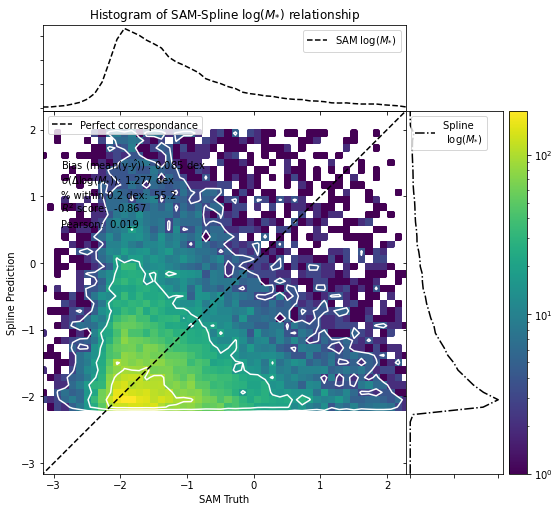

In [9]:
from matplotlib.ticker import NullFormatter
from scipy import stats

pred1=splineMhftr(Mhfte)

target=r"log($M_{*}$)"

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.63
bottom, height = 0.1, 0.63
bottom_h = left_h = left + width
# rect_Cbar = [0, bottom, 0.1, height]
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.15]
rect_histy = [left_h, bottom, 0.15+0.06, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))
# axCbar = plt.axes(rect_Cbar)
axHist = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)

bins=50
l=0.01
xt=0.05
yt=0.8
n_contour=4
# the scatter plot:
vals, x, y, hist =axHist.hist2d( yste, pred1,bins=bins, range=[np.percentile(np.hstack([yste,pred1]), [0+l,100-l]),
                            np.percentile(np.hstack([yste,pred1]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
axHist.plot([min(yste),max(yste)],[min(yste),max(yste)], 'k--', label='Perfect correspondance')
axHist.set(xlabel='SAM Truth',ylabel='Spline Prediction')
axHist.legend()


X, Y = X[0], Y.T[0]
axHist.set_xlim((min(X), max(X)))
axHist.set_ylim((min(Y), max(Y)))
yhat=r'$\hat{y}$'
pct=np.sum((yste-pred1)<0.2)/len(yste-pred1)

r2=r2_score(yste,pred1)
rho = np.corrcoef(yste,pred1)[0,1]
axHist.text(xt,yt+0.04, f'Bias (mean(y-{yhat})) : {np.mean(yste-pred1):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt, r'$\sigma$'+f'($\Delta${target}): '+f'{np.std(yste-pred1):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt-0.04, '% within 0.2 dex:  '+f'{pct*100:.1f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.08, r'$R^2$ score:  '+f'{r2:.3f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.12, r'Pearson:  '+f'{rho:.3f}', transform=axHist.transAxes)



# axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
# axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
ys_kde = stats.gaussian_kde(yste, 0.05)
pred_kde = stats.gaussian_kde(pred1, 0.05)
axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM {target}')
axHisty.plot(pred_kde(Y), Y, "k-.", label=f'Spline \n {target}')
axHistx.legend()
axHisty.legend(loc='upper left')

axHistx.set(title=f'Histogram of SAM-Spline {target} relationship')

axHistx.set_xlim(axHist.get_xlim())
axHisty.set_ylim(axHist.get_ylim())

plt.colorbar(hist, ax=axHisty, location='right')

# plt.show()

plt.savefig('../paper_figures/SAM_Spline.png')



In [10]:
Mhf_am,Ms_am=np.sort([Mhfte,yste], axis=1)

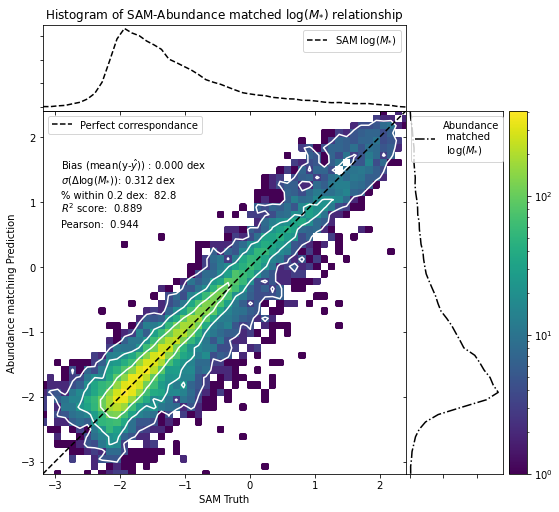

In [11]:
from matplotlib.ticker import NullFormatter
from scipy import stats

pred1=Ms_am

target=r"log($M_{*}$)"

nullfmt = NullFormatter()         # no labels

# definitions for the axes
left, width = 0.1, 0.63
bottom, height = 0.1, 0.63
bottom_h = left_h = left + width
# rect_Cbar = [0, bottom, 0.1, height]
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.15]
rect_histy = [left_h, bottom, 0.15+0.06, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))
# axCbar = plt.axes(rect_Cbar)
axHist = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

# no labels
axHistx.xaxis.set_major_formatter(nullfmt)
axHisty.yaxis.set_major_formatter(nullfmt)
axHistx.yaxis.set_major_formatter(nullfmt)
axHisty.xaxis.set_major_formatter(nullfmt)

bins=50
l=0.01
xt=0.05
yt=0.8
n_contour=4
# the scatter plot:
vals, x, y, hist =axHist.hist2d( yste, pred1,bins=bins, range=[np.percentile(np.hstack([yste,pred1]), [0+l,100-l]),
                            np.percentile(np.hstack([yste,pred1]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white')
axHist.plot([min(yste),max(yste)],[min(yste),max(yste)], 'k--', label='Perfect correspondance')
axHist.set(xlabel='SAM Truth',ylabel='Abundance matching Prediction')
axHist.legend()


X, Y = X[0], Y.T[0]
axHist.set_xlim((min(X), max(X)))
axHist.set_ylim((min(Y), max(Y)))
yhat=r'$\hat{y}$'
pct=np.sum((yste-pred1)<0.2)/len(yste-pred1)

r2=r2_score(yste,pred1)
rho = np.corrcoef(yste,pred1)[0,1]
axHist.text(xt,yt+0.04, f'Bias (mean(y-{yhat})) : {np.mean(yste-pred1):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt, r'$\sigma$'+f'($\Delta${target}): '+f'{np.std(yste-pred1):.3f} dex', transform=axHist.transAxes)
axHist.text(xt,yt-0.04, '% within 0.2 dex:  '+f'{pct*100:.1f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.08, r'$R^2$ score:  '+f'{r2:.3f}', transform=axHist.transAxes)
axHist.text(xt,yt-0.12, r'Pearson:  '+f'{rho:.3f}', transform=axHist.transAxes)



# axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
# axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
ys_kde = stats.gaussian_kde(yste, 0.05)
pred_kde = stats.gaussian_kde(pred1, 0.05)
axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM {target}')
axHisty.plot(pred_kde(Y), Y, "k-.", label=f'Abundance\n matched\n {target}')
axHistx.legend()
axHisty.legend(loc='upper left')

axHistx.set(title=f'Histogram of SAM-Abundance matched {target} relationship')

axHistx.set_xlim(axHist.get_xlim())
axHisty.set_ylim(axHist.get_ylim())

plt.colorbar(hist, ax=axHisty, location='right')
# plt.show()
plt.savefig('../paper_figures/SAM_abundance.png')

In [17]:
from matplotlib.ticker import NullFormatter
from scipy import stats
from matplotlib.ticker import NullFormatter
from scipy import stats

def multi_plot(yss, preds):
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax = ax.flatten()
#     target=r"log($SFR/M_{\odot}/yr$)"
    targets=[r"$log(v_{disk})$", r"log($M_{cold}/M_{\odot}$)", r"log($SFR/M_{\odot}/yr$)"]
    targets = [r"$M_{*}$", r"$M_{*}$",]
    titles =['SAM-GNN', 'Abundance Matching']
    # target=r"$v_{disk}$"
    for i in range(2):
        target=targets[i]
        ys = yss[:,i]
        pred = preds[:,i]
        nullfmt = NullFormatter()         # no labels
        # definitions for the axes
        left, width = 0.1, 0.67
        bottom, height = 0.0, 0.75
        bottom_h = bottom +height
        left_h = left + width
        # rect_Cbar = [0, bottom, 0.1, height]
        rect_scatter = [left, bottom, width, height]
        rect_histx = [left, bottom_h, width, 0.15]
        rect_histy = [left_h, bottom, 0.15+0.01, height]
#             rect_cbar = [left_h+0.15+0.06, bottom, 0.05, height]

        # start with a rectangular Figure
        ax[i].set_axis_off()
        # axCbar = plt.axes(rect_Cbar)
        axHist = ax[i].inset_axes(rect_scatter)
        axHistx = ax[i].inset_axes(rect_histx)
        axHisty = ax[i].inset_axes(rect_histy)
#             axCbar = ax[i][j].inset_axes(rect_cbar)

        # no labels
        axHistx.xaxis.set_major_formatter(nullfmt)
        axHisty.yaxis.set_major_formatter(nullfmt)
        axHistx.yaxis.set_major_formatter(nullfmt)
        axHisty.xaxis.set_major_formatter(nullfmt)

        bins=50
        l=0.0
        n_contour=4
        # the scatter plot:
        vals, x, y, hist =axHist.hist2d( ys, pred,bins=bins, range=[np.percentile(np.hstack([ys,pred]), [0+l,100-l]),
                                    np.percentile(np.hstack([ys,pred]), [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.viridis)
        X, Y = np.meshgrid((x[1:]+x[:-1])/2, (y[1:]+y[:-1])/2)
        axHist.contour(X,Y, np.log(vals.T+1), levels=n_contour, colors='white', linestyles='dashed', linewidths=1.2)
        axHist.plot([min(ys),max(ys)],[min(ys),max(ys)], 'k--', label='Perfect correspondance')
        if i==0:
            axHist.set(xlabel=f'SAM {target}',ylabel=f'GNN {target}', xticks=[5,6,7,8,9,10,11])
        else:
            axHist.set(xlabel=f'SAM {target}',ylabel=f'Abundance matched {target}', xticks=[5,6,7,8,9,10,11])
        if i==0:
            axHist.legend(loc='lower right', fontsize=14)
            

        X, Y = X[0], Y.T[0]
        axHist.set_xlim((min(X), max(X)))
        axHist.set_ylim((min(Y), max(Y)))
        yhat=r'$\hat{y}$'

        #calculate metrics
        pct=np.sum(np.abs(ys-pred)<0.2)/len(ys-pred)    
        r2=r2_score(ys,pred)
        rho = np.corrcoef(ys,pred)[0,1]
        print(np.std(ys-pred),np.mean(ys-pred), pct, r2, rho)

        xt=0.03
        yt=0.85
        dy=0.07
        font = {'weight': 'normal',
            'size': 15}

        axHist.text(xt,yt, f'Bias : {np.mean(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-dy, r'$\sigma$ : '+f'{np.std(ys-pred):.3f} dex', fontdict=font, transform=axHist.transAxes)
        axHist.text(xt,yt-2*dy, r'Pearson:  '+f'{rho:.3f}', fontdict=font, transform=axHist.transAxes)
#             axHist.text(xt,yt-3*dy, r'$R^2$:  '+f'{r2:.3f}', fontdict=font, transform=axHist.transAxes)

#             axHist.text(xt,yt-4*dy, '% < 0.2 dex:  '+f'{pct*100:.1f}', fontdict=font, transform=axHist.transAxes)


        # axHistx.hist(ys[:,n], bins=bins, histtype='step', density=1)
        # axy=axHisty.hist(pred[:,n], bins=bins, histtype='step', density=1, orientation='horizontal')
        ys_kde = stats.gaussian_kde(ys, 0.1)
        pred_kde = stats.gaussian_kde(pred, 0.1)
        axHistx.plot(X, ys_kde(X), 'k--', label=f'SAM')
        axHisty.plot(pred_kde(Y), Y, "k-.", label=f'GNN')
        axHistx.legend(loc='upper right',fontsize=12)
        axHisty.legend(loc='upper left', bbox_to_anchor=(0.,1.125), fontsize=12)

        axHistx.set(title=f'{titles[i]} {target} relationship')

        axHistx.set_xlim(axHist.get_xlim())
        axHisty.set_ylim(axHist.get_ylim())

        divider = make_axes_locatable(axHisty)
        cax = divider.append_axes("right", size="5%", pad=0.0)
        divider = make_axes_locatable(axHist)
#             cax = divider.append_axes("left", size="15%", pad=0.18)

        # Plot vertical colorbar
        plt.colorbar(hist, cax=cax)
#             plt.show()
#             plt.colorbar(hist, ax=axCbar)

#             plt.show()
#     fig.tight_layout()
#     plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=None)
    return fig

In [18]:
# # this is the correlated run

# folder = 'results_final_Gauss4d_020222'
# run='Sage_vlarge_all_4t_z0.0_quantile_raw_ppzquc_4_6'
# pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    
# results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
# config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
# ys, pred = results['low_ys']+9, results['low_pred']+9
# mstar_ys, mstar_pred = ys[:,0], pred[:,0]
# yss, preds = np.vstack([mstar_ys, yste+9]).T, np.vstack([mstar_pred, pred1+9]).T

In [19]:
folder = 'results_final_Z_300322'
run= 'Sage_vlarge_all_allt_z0.0_quantile_raw_rm_mllteo'

pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
ys, pred = results['low_ys'], results['low_pred']
mstar_ys, mstar_pred = ys[:,0]+9, pred[:,0]+9
# mcold_ys, mcold_pred = ys[:,2]+9, pred[:,2]+9

Zy, Zpred = ys[:,2]+9, pred[:,2]+9
Coldy, Coldpred = ys[:,1]+9, pred[:,1]+9
sfr_ys, sfr_pred = ys[:,3], pred[:,3]
sfr100_ys, sfr100_pred = ys[:,4], pred[:,4]
Mbh_ys, Mbh_pred = ys[:,5]+9, pred[:,5]+9

Zy-=Coldy
Zpred-=Coldpred

ys = np.vstack([ mstar_ys, Coldy, Zy, sfr_ys, sfr100_ys, Mbh_ys]).T
pred = np.vstack([mstar_pred, Coldpred, Zpred, sfr_pred, sfr100_pred, Mbh_pred]).T

In [20]:
yss, preds = np.vstack([mstar_ys, yste+9]).T, np.vstack([mstar_pred, pred1+9]).T

0.07047475 0.0016312236 0.9818718575580054 0.9943378149328111 0.9971754679392861
0.31218123 2.1115534e-09 0.6411273582729831 0.8889552686034705 0.94447763427147


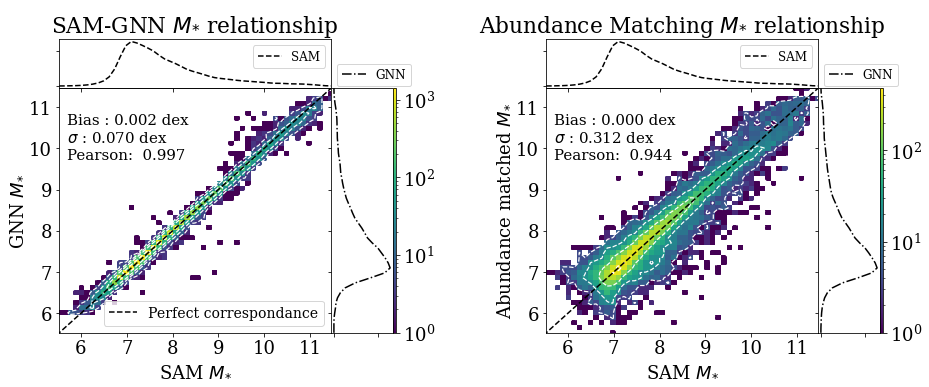

In [21]:
import matplotlib
font = {'family' : 'Serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

fig=multi_plot(yss, preds)
fig.savefig('../paper_figures/performance_mstar_final.png')